In [1]:
import torch
import os 
import gc

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

c:\Users\Sanya\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Устройство для обучения
device

device(type='cpu')

## Настройка параметров

In [3]:
pretrained = False  # Пропустить обучение модели

# Директории с датасетами
train_path        = './train/'
train_labels_path = './train_labels/'

val_path        = './val'
val_labels_path = './val_labels/'

test_path        = './test'
test_labels_path = './test_labels./'

# Настройки преобразований изображений
size = 224                    # До какого размера изменить входное изображение
mean = [0.485, 0.456, 0.406]  # Среднее значение для нормирования каналов
std = [0.229, 0.224, 0.225]   # Стандратное отклонение для нормирования каналов

num_epochs = 15
batch_size = 64
lr = 0.004

# Параметры оптимизатора
momentum = 0.9

# Параметры планировщика
factor = 0.1       # Коэффициент снижения learning rate
patience = 3       # Количество эпох без улучшений
threshold = 0.005  # Порог для изменения learning rate

In [4]:
# Преобразование изображений
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()])
    #transforms.Normalize(mean = mean, std = std)]) # Нормирование каждого канала изображения

## Подготовка датасетов

In [5]:
class road_Dataset(Dataset):

    def __init__(self, images_dir, masks_dir, transforms = None):

        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.images     = os.listdir(images_dir)
        self.masks      = os.listdir(masks_dir)
        self.transforms = transforms

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.images_dir, self.images[idx])).convert('RGB')

        if self.transforms:
            image = self.transforms(image)
            
        mask = Image.open(os.path.join(self.masks_dir, self.masks[idx])).convert('RGB')

        if self.transforms:
            mask = self.transforms(mask)
    
        return image, mask
    
    def __len__(self):
        return len(self.images)

In [6]:
# Создание датасетов
train_dataset = road_Dataset(train_path, train_labels_path, transforms = transform)
#val_dataset   = road_Dataset(val_path, val_labels_path)
#test_dataset  = road_Dataset(test_path, test_labels_path)

n_train = len(train_dataset) # Количество изображений в тренировочном датасете
#n_val   = len(val_dataset)   # Количество изображений в валидационном датасете
#n_test  = len(test_dataset)  # Количество изображений в тестовом датасете

## Создание загрузчиков 

In [7]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
#val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
#test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)

## Вывод изображений с масками

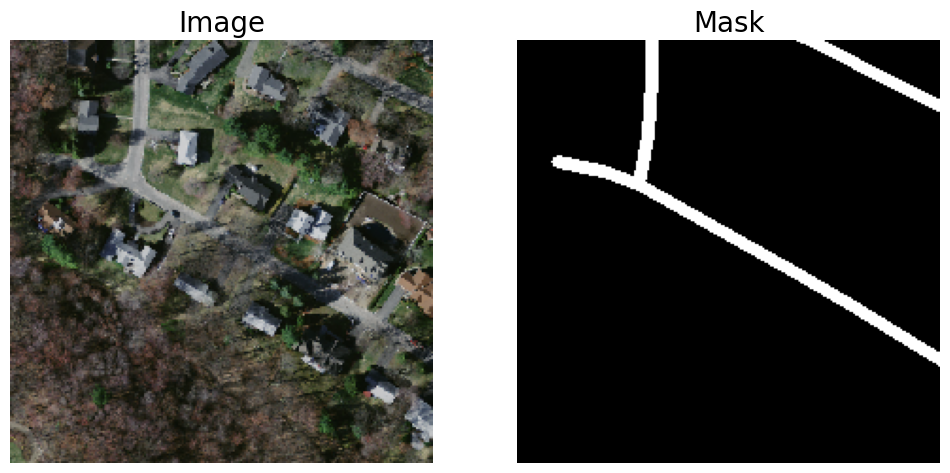

In [16]:
# Вывод заданного количества изображений
def imshow(images, masks, cnt):

    # Подготовка холста для изображений
    fig, axs = plt.subplots(cnt, 2)
    axs = axs.flatten()

    fig.set_figwidth(12)
    fig.set_figheight(cnt * 6)

    for i, (image, mask) in enumerate(zip(images[:cnt], masks[:cnt])):
        
        # Приведение массивов к формату (H, W, Ch)
        npimg = image.numpy()
        npmask = mask.numpy()

        npimg = np.transpose(npimg, (1, 2, 0)).squeeze()
        npmask = np.transpose(npmask, (1, 2, 0)).squeeze()

        # Вывод изображения
        axs[i * 2].imshow(npimg)
        axs[i * 2 + 1].imshow(npmask)

        axs[i * 2].set_axis_off()
        axs[i * 2 + 1].set_axis_off()

        if i == 0:
            axs[0].set_title('Image', fontsize = 20)
            axs[1].set_title('Mask', fontsize = 20)

    plt.show()
   
# Получить случайные тренировочные изображения
dataiter = iter(train_loader)
images, masks = next(dataiter)

imshow(images, masks, 1)